In [12]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras import models

In [13]:
train_ds, test_ds , val_ds= tfds.load('eurosat/rgb', split=['train[:60%]', 'train[60%:80%]', 'train[80%:]'], shuffle_files=False, as_supervised=True)

In [14]:
labels = []
for _, label in train_ds:
    labels.append(label.numpy())
labels = np.unique(labels)

In [15]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32
img_height=64
img_width =64
IMG_SIZE = (img_height, img_width)
def resize_image(images, labels):
    images = tf.image.resize(images, IMG_SIZE)
    return images, labels

In [16]:
train_ds = train_ds.map(resize_image).cache().shuffle(BUFFER_SIZE)\
    .batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.map(resize_image).batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.map(resize_image).batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
tf.keras.utils.set_random_seed(42)

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10)
])

In [18]:
# Compile the model
model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [19]:
history = model.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
507/507 [==============================] - 23s 44ms/step - loss: 1.2764 - accuracy: 0.5065 - val_loss: 0.8229 - val_accuracy: 0.6869
Epoch 2/15
507/507 [==============================] - 29s 57ms/step - loss: 0.8147 - accuracy: 0.7058 - val_loss: 0.6731 - val_accuracy: 0.7496
Epoch 3/15
507/507 [==============================] - 34s 67ms/step - loss: 0.6812 - accuracy: 0.7523 - val_loss: 0.5858 - val_accuracy: 0.7852
Epoch 4/15
507/507 [==============================] - 26s 52ms/step - loss: 0.5975 - accuracy: 0.7843 - val_loss: 0.5772 - val_accuracy: 0.7856
Epoch 5/15
507/507 [==============================] - 22s 44ms/step - loss: 0.5156 - accuracy: 0.8151 - val_loss: 0.6077 - val_accuracy: 0.7928
Epoch 6/15
507/507 [==============================] - 36s 72ms/step - loss: 0.4608 - accuracy: 0.8357 - val_loss: 0.6201 - val_accuracy: 0.7656
Epoch 7/15
507/507 [==============================] - 25s 49ms/step - loss: 0.4167 - accuracy: 0.8506 - val_loss: 0.5328 - val_accuracy:

In [20]:
test_loss, test_acc = model.evaluate(test_ds)
print('Test accuracy: ', test_acc)

169/169 [==============================] - 2s 9ms/step - loss: 0.5661 - accuracy: 0.8572
Test accuracy:  0.8572221994400024


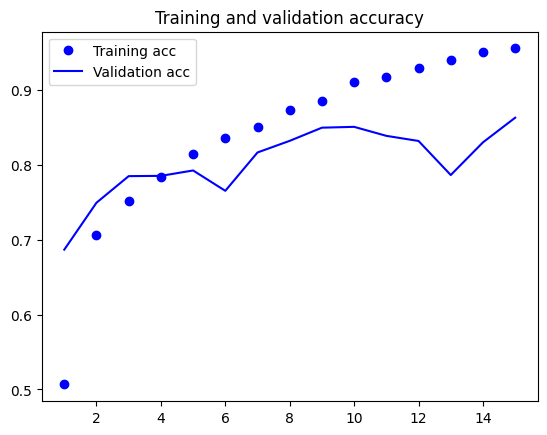

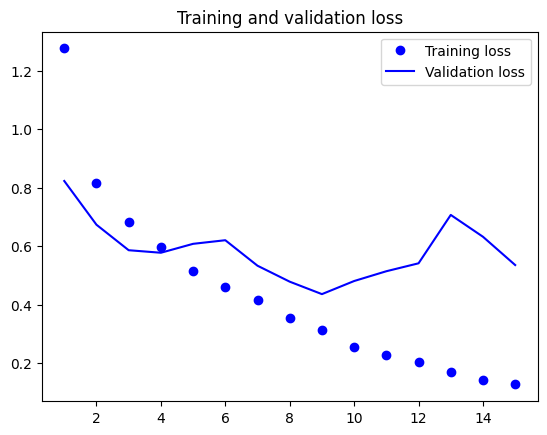

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

169/169 [==============================] - 2s 9ms/step


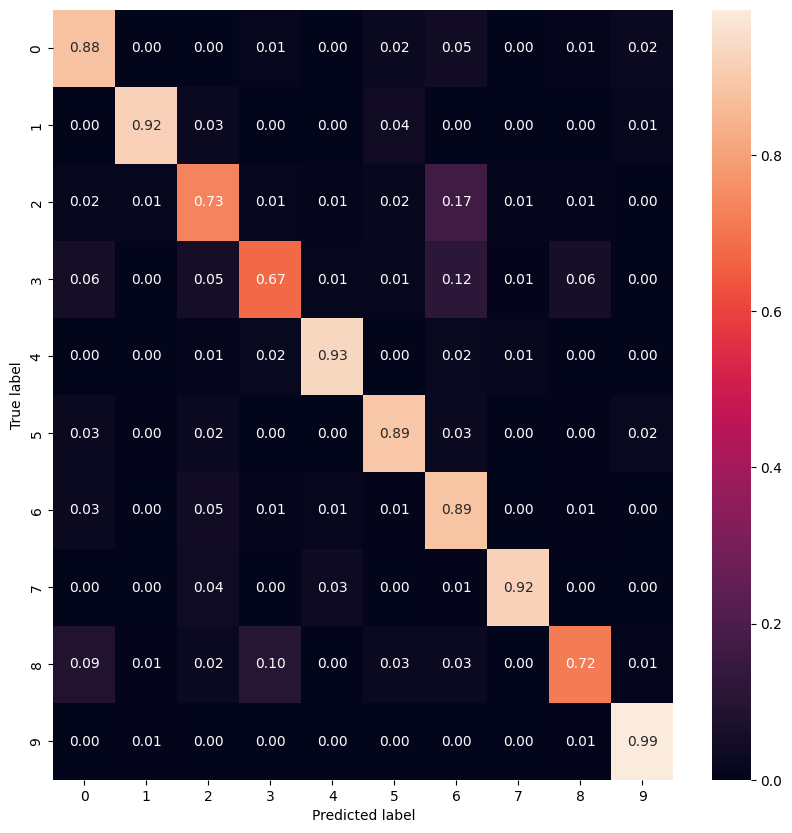

In [22]:
# Show the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = []
for _, label in test_ds:
    y_true.append(label.numpy())
y_true = np.concatenate(y_true)

cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       598
           1       0.97      0.92      0.94       593
           2       0.79      0.73      0.76       611
           3       0.79      0.67      0.73       461
           4       0.93      0.93      0.93       504
           5       0.84      0.89      0.87       446
           6       0.67      0.89      0.77       524
           7       0.97      0.92      0.95       599
           8       0.87      0.72      0.79       493
           9       0.94      0.99      0.96       571

    accuracy                           0.86      5400
   macro avg       0.86      0.85      0.85      5400
weighted avg       0.86      0.86      0.86      5400

